In [1]:
#insert path to programs file
curdir = '/home/lagrange2/Documents/school/Illinois/My Own work/waveform project/programs'
# insert path to local caffe directory / python
caffePath = '/home/lagrange2/caffe/python'

import argparse
import os
import time

#switch to program path to curdir to import local libraries
os.chdir(curdir)
import filter_evaluation_functions as mef
import visualization_functions as vf
import math, cmath
reload(mef)

#import local caffe program, not the universal but incompatible one.
os.chdir(caffePath)

from google.protobuf import text_format
import numpy as np
import PIL.Image
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.colors as colors
os.environ['GLOG_minloglevel'] = '2' # Suppress most caffe output
import caffe
from caffe.proto import caffe_pb2

os.chdir(curdir)


In [2]:
# path/to/model.prototxt file
mod = '/home/lagrange2/caffe/models/bvlc_refference_detectnet/deploy.prototxt'
# path/to/model.caffmodel file
weights = '/home/lagrange2/digits/DIGITS/digits/jobs/20181112-163907-b425/snapshot_iter_2574.caffemodel'

#path/to/test/images
image_path = '/home/lagrange2/Documents/school/Illinois/My Own work/waveform project/test/images/'
#path/to/text/labels
label_path = '/home/lagrange2/Documents/school/Illinois/My Own work/waveform project/test/labels/'


#Gets all images with at least 20 cars, limit is 1000 images
num_cars = 20
tries = 1000
i = 0
counter = 0
files = os.listdir(image_path)
good_filenames=[]

while (i < len(files)) & (counter < tries):
    lab_path = label_path + files[i][:-3]+'txt'
    im_path = image_path + files[i]
    number = len(open(lab_path,'r').read().split('\n')[:-1])
    if number >= num_cars:
        good_filenames = good_filenames+[files[i][:-4]]
        counter+=1
    i+=1    

In [ ]:
#creates lowpass coverage map file cvgs_20_plus-lowpass-.npy
bigargs =  [['lowpass', i*24.0/150.0, 0.0, 0.0] for i in range(151)]

mef.uncertainty_cvg_maps(good_filenames, bigargs,
                        weights = weights, mod = mod7, 
                        filenamelist=None, mode='RGB',cvg_z = None, 
                        modify_name ='')

In [ ]:
#creates highpass coverage map file cvgs_20_plus-highpass-.npy
bigargs =  [['highpass', i*1.0/150.0, 0.0, 0.0] for i in range(151)]

mef.uncertainty_cvg_maps(good_filenames, bigargs,
                        weights = weights7, mod = mod7, 
                        filenamelist=None, mode='RGB',cvg_z = None, 
                        modify_name ='')


In [ ]:
#creates notch coverage map file cvgs_20_bandpass_inverse-notch-10.npy
bigargs =  [['bandpass_inverse', 0.01, i*0.01, 0.1] for i in range(70)]

cvg_maps_low = mef.uncertainty_cvg_maps(good_filenames, bigargs,
                        weights =weights, mod = mod, 
                        filenamelist=None, mode='RGB',cvg_z = None, 
                        modify_name = 'notch-10')


In [ ]:
#creates notch coverage map file cvgs_20_bandpass_inverse-notch-05.npy
bigargs =  [['bandpass_inverse', 0.01, i*0.01, 0.05] for i in range(70)]

cvg_maps_low = mef.uncertainty_cvg_maps(good_filenames, bigargs,
                        weights =weights, mod = mod, 
                        filenamelist=None, mode='RGB',cvg_z = None, 
                        modify_name = 'notch-05')

In [90]:
# must be in curdir to execute this block
os.chdir(curdir)
Coverages = np.load('cvgs_20_plus-lowpass.npy')
reload(mef)
zfc = []

#create a collection of lowpass uncertainty curves. 
#zfc[m][k] gives the certainty curve 
#for the kth good car in the mth good image

for k in range(0,len(good_filenames)):
    new_data, data_index, data, img, sigmas,img_transform = mef.get_good_img_data(k,good_filenames,label_path,image_path)
    for i in range(len(new_data)):
        new_data[i] = np.append(new_data[i],1)
        
    new_data = np.asarray(new_data)

    if len(new_data) > 0:
        z = mef.prediction_certainty_curve(new_data*4.0,Coverages[k], thresh=0.0, avg = 'center')
        zfc = zfc+[z]

    else:    
        zfc = zfc+[[]]

#create a collection of highpass uncertainty curves        
Coverages = np.load('cvgs_20_plus-highpass-.npy')
zfc2 = []

for k in range(0,len(good_filenames)):
    new_data, data_index, data, img, sigmas,img_transform = mef.get_good_img_data(k,good_filenames,label_path,image_path)
    for i in range(len(new_data)):
        new_data[i] = np.append(new_data[i],1)
        
    new_data = np.asarray(new_data)

    if len(new_data) > 0:
        z = mef.prediction_certainty_curve(new_data*4,Coverages[k], thresh=0.0, avg = 'center')
        zfc2 = zfc2+[z]
    else:    
        zfc2 = zfc2+[[]]

        

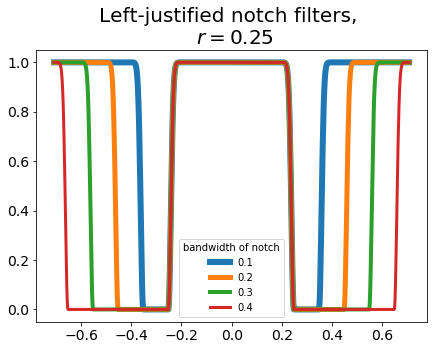

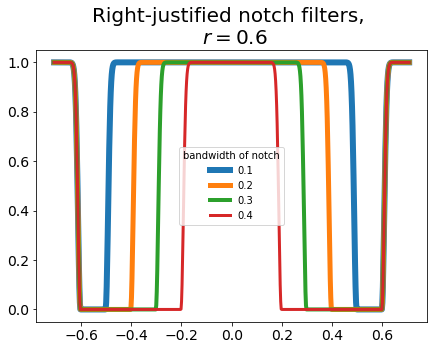

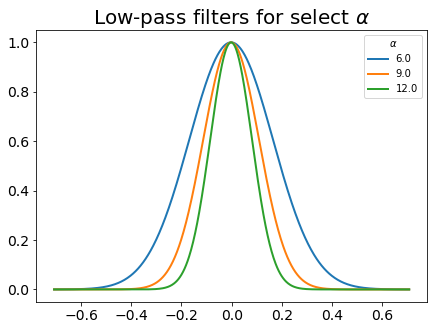

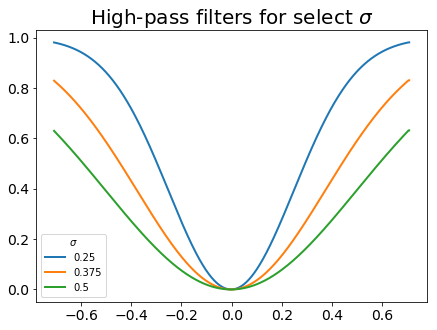

In [95]:
#make sure we are in curdir

#This block makes the plots of the filters presented in the paper
os.chdir(curdir)

x = np.arange(-351,352)
y = np.arange(-351,352)
r=0.25
eps = 0.1


size = 20
ticknumsize = 14

#left justified notch filters (figure 14)
plt.figure(figsize = (7,5))

for k,j in enumerate(np.linspace(0.1,0.40,4)):
    highfilt =np.fft.fftshift(mef.freqfilter(x[:],
            x,['bandpass_inverse', 0.01,r, j, 1, 'left']))
    sectionhigh = [highfilt[i,i] for i in range(len(x))]
    plt.plot(np.linspace(-0.5**0.5,0.5**0.5,703), sectionhigh, linewidth =6-k)

    
plt.legend([0.1,0.2,0.3,0.4], title ='bandwidth of notch') 
plt.title('Left-justified notch filters, \n $r=0.25$',size = size)
plt.xticks(size = ticknumsize)
plt.yticks(size = ticknumsize)
#plt.savefig('../paper/figures/left-justified-notch.eps')
r=0.6
eps = 0.1

# right justified notch filters (figure 15)
plt.figure(figsize = (7,5))
for k,j in enumerate(np.linspace(0.1,0.40,4)):
    highfilt =np.fft.fftshift(mef.freqfilter(x[:],
            x,['bandpass_inverse', 0.01,r, j,1, 'right']))
    sectionhigh = [highfilt[i,i] for i in range(len(x))]
    plt.plot(np.linspace(-0.5**0.5,0.5**0.5,703), sectionhigh,  linewidth = 6 - k)
plt.xticks(size = ticknumsize)
plt.yticks(size = ticknumsize)    
plt.legend([0.1,0.2,0.3,0.4], title ='bandwidth of notch') 
plt.title('Right-justified notch filters, \n $r = 0.6$',size = size)
#plt.savefig('../paper/figures/right-justified-notch.eps')

#lowpass filters (figure 1)
plt.figure(figsize = (7,5))
for j in np.linspace(6,12,3):
    #print sig
    highfilt =np.fft.fftshift(mef.freqfilter(x[:],
            x,['lowpass',j,0, 0]))
    
    sectionhigh = [highfilt[i,i] for i in range(len(x))]
    plt.plot(np.linspace(-0.5**0.5,0.5**0.5,703), sectionhigh, linewidth = 2)
plt.xticks(size = ticknumsize)
plt.yticks(size = ticknumsize)    
plt.legend(np.linspace(6,12,3), title ='$\\alpha$') 
plt.title('Low-pass filters for select $\\alpha$',size = size)
plt.savefig('../paper/figures/lowpass.eps')

#highpass filters (figure 2)
plt.figure(figsize = (7,5))
for j in np.linspace(0.25,0.5,3):
    #print sig
    highfilt =np.fft.fftshift(mef.freqfilter(x[:],
            x,['highpass',j,0, 0]))
    
    sectionhigh = [highfilt[i,i] for i in range(len(x))]
    plt.plot(np.linspace(-0.5**0.5,0.5**0.5,703), sectionhigh, linewidth = 2)
plt.xticks(size = ticknumsize)
plt.yticks(size = ticknumsize)    
plt.legend(np.linspace(0.25,.5,3), title ='$\sigma$') 
plt.title('High-pass filters for select $\sigma$', size = size)
plt.savefig('../paper/figures/highpass.eps')

In [91]:

# get list of lowpass and highpass cutoffs and threshold points for
# all good cars with certainty scores greater than 10/19
cutoffs_lowpass = []
high_thresh_lowpass = []
low_thresh_lowpass = []

cutoffs_highpass = []
high_thresh_highpass = []
low_thresh_highpass = []
for m in range(0,161):#len(good_filenames)):
    start = time.time()
    for k in range(len(zfc[m])):
        if zfc[m][k][0] > 0.527:
            sigmas = np.linspace(0,24,151)
            [cutoff, sigmax, sigmin],zargmax, zargmin = mef.find_midpoint_of_curve(zfc[m][k], sigmas)
            [sigmax, sig1, sig2],_,_ = mef.find_midpoint_of_curve(zfc[m][k], sigmas,threshold = 0.95)
            [sigmin, sig1, sig2],_,_ = mef.find_midpoint_of_curve(zfc[m][k], sigmas, threshold = 0.05)

            cutoffs_lowpass = cutoffs_lowpass +[cutoff]
            high_thresh_lowpass = high_thresh_lowpass +[sigmax]
            low_thresh_lowpass = low_thresh_lowpass +[sigmin]

            sigmas = np.linspace(0,1,151)
            [cutoff, sigmax, sigmin],zargmax, zargmin = mef.find_midpoint_of_curve(zfc2[m][k], sigmas)
            [sigmax, sig1, sig2],_,_ = mef.find_midpoint_of_curve(zfc2[m][k], sigmas,threshold = 0.95)
            [sigmin, sig1, sig2],_,_ = mef.find_midpoint_of_curve(zfc2[m][k], sigmas, threshold = 0.05)

            cutoffs_highpass = cutoffs_highpass +[cutoff]
            high_thresh_highpass = high_thresh_highpass +[sigmax]
            low_thresh_highpass = low_thresh_highpass +[sigmin]
    end = time.time()


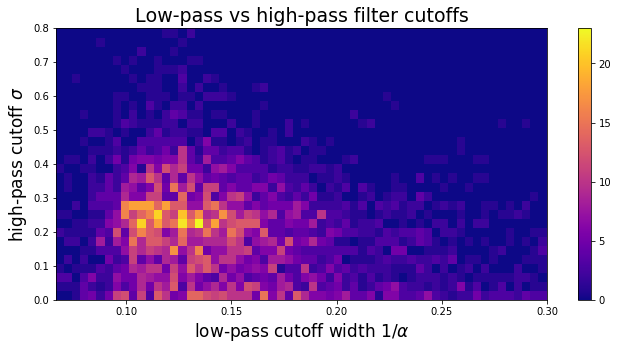

In [92]:
# creates top image in figure 4
f, ax = plt.subplots(1,1, figsize = (11,5))
xedges = np.linspace(1/15.0,0.3,61)
yedges = np.linspace(0,0.8,31)
cmap = 'plasma'
H1, xedges1, yedges1 = np.histogram2d(list(1/np.array(cutoffs_lowpass)),cutoffs_highpass, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T, cmap = cmap)
plt.title('Low-pass vs high-pass filter cutoffs', size=19)
plt.xlabel('low-pass cutoff width $1/\\alpha$', size = 17)
plt.ylabel('high-pass cutoff $\sigma$',size = 17)
plt.colorbar()
plt.savefig('../paper/figures/lowpass-vs-highpass-inverse.eps')

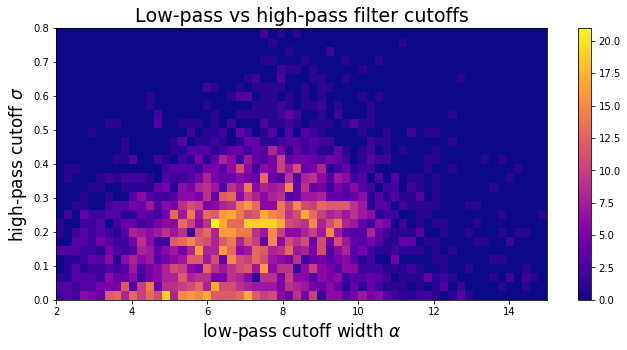

In [93]:
#creates bottom image in figure 4
f, ax = plt.subplots(1,1, figsize = (11,5))
xedges = np.linspace(2.0,15,61)
yedges = np.linspace(0,0.8,31)
cmap = 'plasma'
H1, xedges1, yedges1 = np.histogram2d(list(np.array(cutoffs_lowpass)),cutoffs_highpass, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T, cmap = cmap)
plt.title('Low-pass vs high-pass filter cutoffs', size=19)
plt.xlabel('low-pass cutoff width $\\alpha$', size = 17)
plt.ylabel('high-pass cutoff $\sigma$',size = 17)
plt.colorbar()
plt.savefig('../paper/lowpass-vs-highpass.eps')

0.15606645011199588 0.20857064616980256


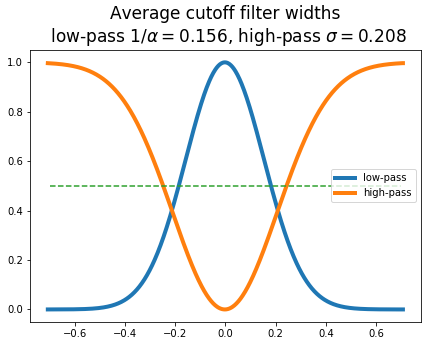

In [94]:
# create figure 5

xs = np.arange(-351,352)
space = np.linspace(-0.5**0.5, 0.5**0.5, 703)
lowpass_sig = 1/np.average(1/np.array(cutoffs_lowpass))
highpass_sig = np.average(cutoffs_highpass)
print 1/lowpass_sig,highpass_sig
#get average lowpass filter at cutoff point
lowfilter =np.fft.fftshift(mef.freqfilter(xs[:],
            xs,['lowpass',lowpass_sig,0, 0]))
sectionlow = [lowfilter[i,i] for i in range(len(xs))]

#get average highpass filter at cutoff point
highfilter =np.fft.fftshift(mef.freqfilter(xs[:],
            xs,['highpass',highpass_sig,0, 0]))
sectionhigh = [highfilter[i,i] for i in range(len(xs))]

plt.figure(figsize = (7,5))
plt.title('Average cutoff filter widths\n low-pass $1/\\alpha = '+str(1/lowpass_sig)[:5]+'$, high-pass $\sigma = '+str(highpass_sig)[:5]+'$', size = 17)
plt.plot(space, sectionlow, linewidth =4)
plt.plot(space, sectionhigh, linewidth =4)
plt.legend(['low-pass', 'high-pass'])
plt.plot([-0.7,0.7],[0.5,0.5], linestyle = '--')

plt.savefig('../paper/average-filter-widths.eps')

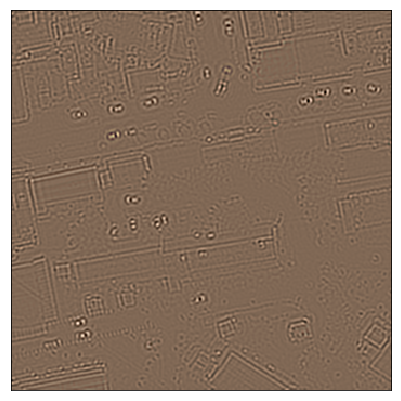

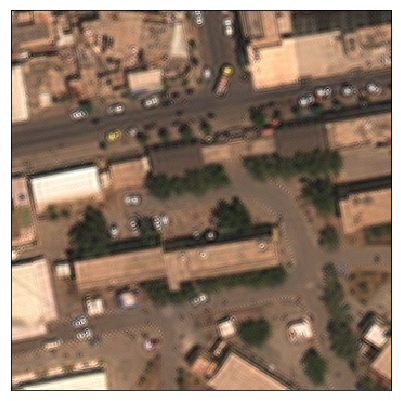

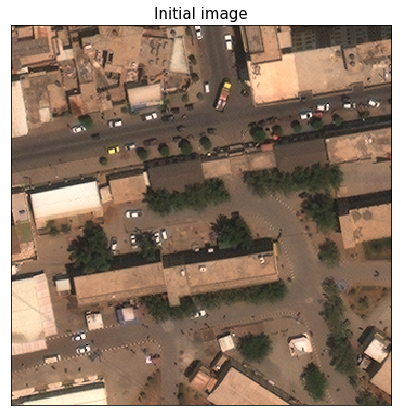

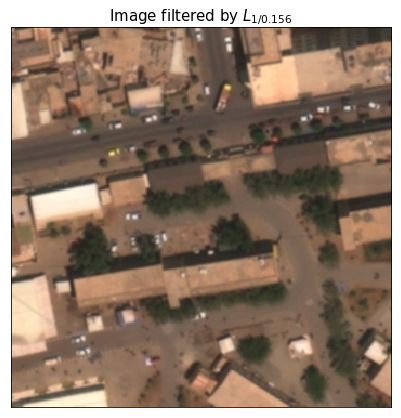

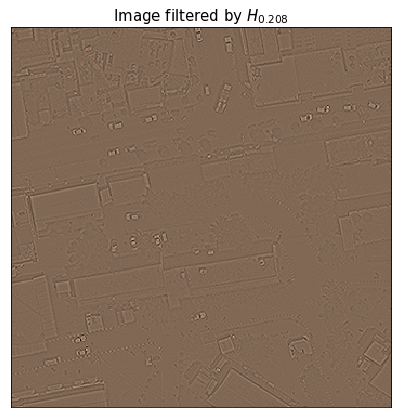

In [111]:
m =13
new_data, data_index, data, img, sigmas,transform = mef.get_good_img_data(m,good_filenames,label_path,image_path)
    

filt_img_band = mef.filter_application(transform, args = ['bandpass', 50, 0.22,0.05, 1])
plt.figure(figsize = (7,7))
plt.imshow(filt_img_band) 
plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.savefig('../paper/bandpass-image.eps')

filt_img_notch = mef.filter_application(transform, args = ['bandpass_inverse', 0.02, 0.22,0.05, 1.0])
plt.figure(figsize = (7,7))
plt.imshow(filt_img_notch) 
plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.savefig('../paper/notch-image.eps')

#filt_img_init = mef.filter_application(transform, args = ['lowpass', 0,0,0])
plt.figure(figsize = (7,7))
plt.imshow(img) 
plt.title('Initial image',size = 15)
plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.savefig('../paper/initial-image.eps')


filt_img_lowpass = mef.filter_application(transform, args = ['lowpass', lowpass_sig, 0,0])
plt.figure(figsize = (7,7))
plt.imshow(filt_img_lowpass)
plt.title('Image filtered by $L_{1/'+str(1/lowpass_sig)[:5]+'}$',size = 15)
plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.savefig('../paper/lowpass-image.eps')


filt_img_highpass = mef.filter_application(transform, args = ['highpass', highpass_sig, 0,0])
plt.figure(figsize = (7,7))
plt.imshow(filt_img_highpass)
plt.title('Image filtered by $H_{'+str(highpass_sig)[:5]+'}$',size = 15)
plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.savefig('../paper/highpass-image.eps')



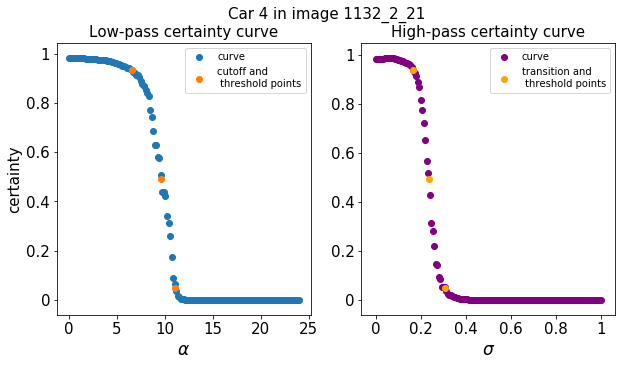

In [97]:
#creates figure 3
reload(vf)
m = 58
k = 4
vf.show_cutoffs(zfc[m][k], zfc2[m][k], 'Car '+str(k)+ ' in image '+good_filenames[m])
plt.savefig('../paper/certainty-curves.eps')

In [22]:
# Get probability distribution for certainties
#use this to generate both images in figure 6

def certainty_cdf(z,filtertype):
    #arranges scores according to intensity of filter
    z_cars = [car for listcar in z for car in listcar]
    plt.figure(figsize = (10,7))
    z_car_ind_scores = [[score[i] for score in z_cars] for i in range(151)]
    
    if filtertype == 'lowpass':
        sigmas = np.linspace(0,24,151)
        m =10
        bartitle = '$\\alpha$'
        filtertypetitle = 'low-pass'
    if filtertype == 'highpass':
        sigmas = np.linspace(0,1,151)
        m= 12
        bartitle = '$\sigma$'
        filtertypetitle = 'high-pass'
        
    k = 121 #only does up to 121 because all 151 makes for very cramped graphics
    plt.title('Reversed cdf of ' +filtertypetitle+ ' objectness scores \n for all images', size = 20)
    plt.xlabel('objectness scores', size = 15)
    plt.xticks(size = 13)
    plt.ylabel('number of cars', size = 15)
    c = np.arange(1., len(range(0,k,m)))

    cmap = plt.get_cmap("nipy_spectral", len(c))
    norm = colors.BoundaryNorm(sigmas[:k:m],len(c))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    for i,sigma_hist in enumerate(z_car_ind_scores[:120:m]):
        plt.hist(sigma_hist,bins =np.linspace(0,1,101), #histtype = 'full',
                 cumulative=-1, label='Empirical', color=cmap(i), alpha = 1)
        

    cbar = plt.colorbar(sm, ticks = sigmas[:k:2*m])
    cbar.ax.tick_params(labelsize = 13)
    cbar.ax.set_title(bartitle, fontsize = 20)
    plt.savefig('../paper/certainty-histograms-distribution-'+filtertype+'.eps')
    plt.show()
    plt.close()
    
    

In [ ]:
#makes both images of figure 6
certainty_cdf(zfc,'lowpass')
certainty_cdf(zfc2,'highpass')

In [28]:
#gets data for a_k^high(r) and a_k^low(r) for all good cars in good images with certainty scores > 10/19

#os.chdir(curdir)
#reload(vf)
#reload(mef)

#sample ranges for obtaining energy levels a_k^high and a_k^low
os.chdir(curdir)

rrrs = np.linspace(0.0,0.69, 70)
huge_rll = [] #lowpass a_k^low(r)
huge_rlh = [] #highpass a_k^high(r)
huge_il = []  #initial energy levles

#this one takes a while as well.  Best to save the results
for m in range(len(good_filenames)):
    start = time.time()
    new_data, data_index, data, img, sigmas,transform = mef.get_good_img_data(m,good_filenames,label_path,image_path)
    
    for k in range(len(zfc[m])):

        if zfc[m][k][0] > 0.527:
            ratio_line_low = []
            ratio_line_high = []
            initial_line = []
            
            sigmas = np.linspace(0,24,151)

            [sigmax, _, _],_,_ = mef.find_midpoint_of_curve(zfc[m][k], sigmas,threshold = 0.95)
            [sigmin,_, _],_,_ = mef.find_midpoint_of_curve(zfc[m][k], sigmas, threshold = 0.05)
            filt_img_max = mef.filter_application(transform, args = ['lowpass', sigmax, 0,0])
            filt_img_min = mef.filter_application(transform,args = ['lowpass', sigmin,0,0])
            Maxpic,_ = mef.small_fourier(filt_img_max, new_data[k],2,0,0)
            Minpic, _ = mef.small_fourier(filt_img_min, new_data[k],2,0,0)
             
            sigmas = np.linspace(0,1,151)

            [sigmax2, _, _],_,_ = mef.find_midpoint_of_curve(zfc2[m][k], sigmas,threshold = 0.95)
            [sigmin2,_, _],_,_ = mef.find_midpoint_of_curve(zfc2[m][k], sigmas, threshold = 0.05)
            filt_img_max = mef.filter_application(transform, args = ['highpass', sigmax2, 0,0])
            filt_img_min = mef.filter_application(transform,args = ['highpass', sigmin2,0,0])
            Maxpic2,_= mef.small_fourier(filt_img_max, new_data[k],2,0,0)
            Minpic2,_ = mef.small_fourier(filt_img_min, new_data[k],2,0,0)
            
            
            for r in rrrs:
                lowdenom = mef.interpolated_frequency_spectrum(Maxpic,r=r, n = 40)
                lownum = mef.interpolated_frequency_spectrum(Minpic,r=r, n = 40)
                
                highdenom = mef.interpolated_frequency_spectrum(Maxpic2,r=r, n = 40)
                highnum = mef.interpolated_frequency_spectrum(Minpic2,r=r, n = 40)
                
                ratio_line_low = ratio_line_low+ [lownum/lowdenom]
                ratio_line_high = ratio_line_high+ [highnum/highdenom]
                initial_line = initial_line + [mef.interpolated_frequency_spectrum(np.abs(mef.small_fourier(img, new_data[k],2,0,0)[0]),r=r,n=40)]


            huge_rll += [ratio_line_low]
            huge_rlh += [ratio_line_high]
            huge_il += [initial_line]

    end = time.time()
    print "went through cars in image "+str(m)+ " in "+str(end-start)[:5]+ " seconds..."

went through cars in image 0 in 37.46 seconds...
went through cars in image 1 in 32.42 seconds...
went through cars in image 2 in 21.73 seconds...
went through cars in image 3 in 37.52 seconds...
went through cars in image 4 in 37.18 seconds...
went through cars in image 5 in 23.31 seconds...
went through cars in image 6 in 37.81 seconds...
went through cars in image 7 in 66.89 seconds...
went through cars in image 8 in 40.41 seconds...
went through cars in image 9 in 45.87 seconds...
went through cars in image 10 in 46.68 seconds...
went through cars in image 11 in 10.58 seconds...
went through cars in image 12 in 49.40 seconds...
went through cars in image 13 in 29.92 seconds...
went through cars in image 14 in 37.15 seconds...
went through cars in image 15 in 32.74 seconds...
went through cars in image 16 in 46.02 seconds...
went through cars in image 17 in 24.18 seconds...
went through cars in image 18 in 20.09 seconds...
went through cars in image 19 in 32.37 seconds...
went throu

In [110]:
#saves the arrays into a .npy file, uncomment below to save
#np.save('critical-frequency-functions.npy',[huge_rll, huge_rlh, huge_il])

#loads the above, so you don't have to run it for long. uncomment to load
#[huge_rll, huge_rlh, huge_il]= np.load('critical-frequency-functions.npy')

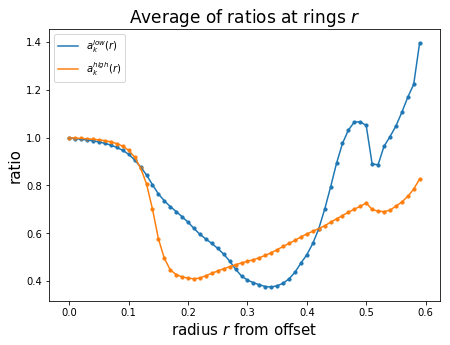

In [43]:
#generates figure 8
k = 7
l = 60
plt.figure(figsize = (7,5))
plt.title('Average of ratios at rings $r$',size = 17)
plt.scatter(rrrs[:l],huge_rll[k][:l],s = 10)
plt.scatter(rrrs[:l], huge_rlh[k][:l],s=10)
plt.plot(rrrs[:l],huge_rll[k][:l])
plt.plot(rrrs[:l], huge_rlh[k][:l])

plt.xlabel('radius $r$ from offset',size = 15)
plt.ylabel('ratio',size = 15)

plt.legend(['$a_k^{low}(r)$', '$a_k^{high}(r)$'])
plt.savefig('../paper/example-good-curves.eps')



In [44]:
#generates big lists full of nice data
lowpass_ratio_minimums = [] #lowpass critical frequencies
highpass_ratio_minimums = [] #highpass critical frequencies
lowpass_ratio_drastic = [] # lowpass frequencies yielding most disparate ratios
highpass_ratio_drastic = [] #highpass frequencies yielding most disparate ratios

for s in range(len(huge_rll)):
    #if
    lowpass_ratio_minimums+= [rrrs[np.argmin(huge_rll[s][:])]]
    highpass_ratio_minimums+= [rrrs[np.argmin(huge_rlh[s][:])]]
    lowpass_ratio_drastic+= [rrrs[np.argmax(np.abs(np.log(huge_rll[s][:])))]]
    highpass_ratio_drastic+= [rrrs[np.argmax(np.abs(np.log(huge_rlh[s][:])))]]

#big fat lists of initial objectness scores
lp_certainties = []
hp_certainties = []

#big fat lists of certainty curves
lp_certainties_curves = []
hp_certainties_curves = []

for m in range(len(good_filenames)):
    for k in range(len(zfc[m])):
        
        if zfc[m][k][0]>0.527:
            lp_certainties+= [zfc[m][k][0]]
            hp_certainties+= [zfc2[m][k][0]]
            lp_certainties_curves += [zfc[m][k]]
            hp_certainties_curves += [zfc2[m][k]]



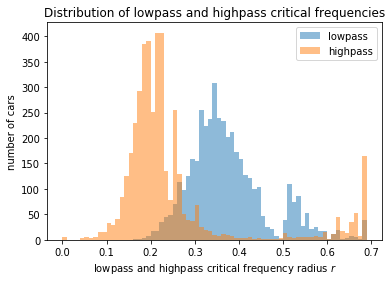

In [70]:
# generates figure 10
plt.figure()
plt.title('Distribution of lowpass and highpass critical frequencies')
plt.hist(lowpass_ratio_minimums,bins =np.linspace(0,0.69,70), alpha = 0.5)
plt.hist(highpass_ratio_minimums,bins =np.linspace(0,0.69,70),alpha = 0.5)
plt.xlabel('lowpass and highpass critical frequency radius $r$')
plt.ylabel('number of cars')
plt.legend(['lowpass', 'highpass'])
plt.savefig('../paper/crit-frequency-1D-histogram.eps')

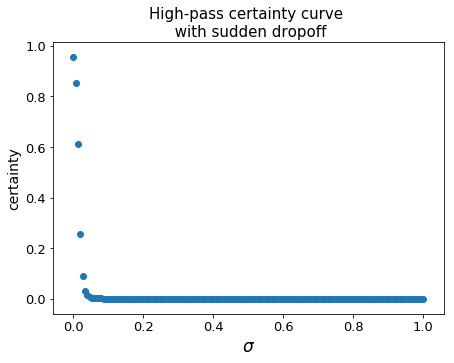

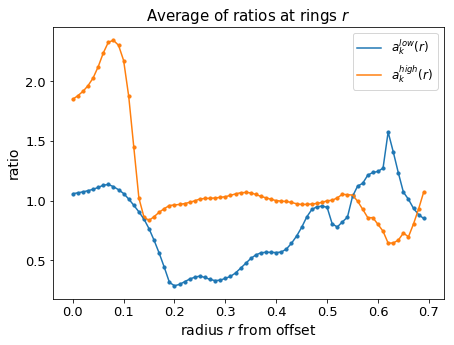

In [46]:
#makes both images of figure 12
k=20

#high-pass certainty curve
plt.figure(figsize = (7,5))
plt.scatter(np.linspace(0,1,151), hp_certainties_curves[k])
plt.title('High-pass certainty curve \n with sudden dropoff',size = 15)
plt.xlabel('$\sigma$',size = 17)
plt.ylabel('certainty',size = 14)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.savefig('../paper/figures/sudden-dropoff-car.eps')


# plot with a_k^low(r) and a_k^high(r)
plt.figure(figsize = (7,5))
plt.title('Average of ratios at rings $r$',size = 15)

plt.scatter(rrrs,huge_rll[k],s = 10)
plt.scatter(rrrs, huge_rlh[k],s=10)
plt.plot(rrrs,huge_rll[k])
plt.plot(rrrs, huge_rlh[k])

plt.xlabel('radius $r$ from offset',size = 14)
plt.ylabel('ratio',size = 14)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.legend(['$a_k^{low}(r)$', '$a_k^{high}(r)$'],fontsize =12)
plt.savefig('../paper/figures/example-bad-curves.eps')




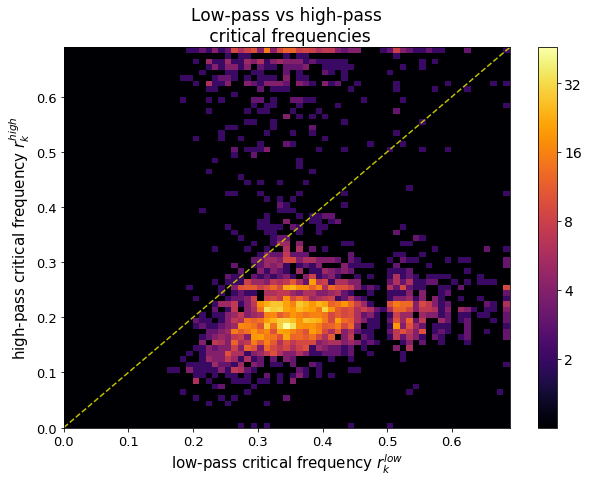

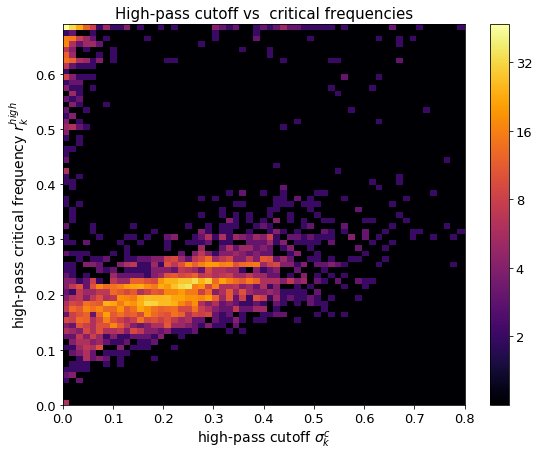

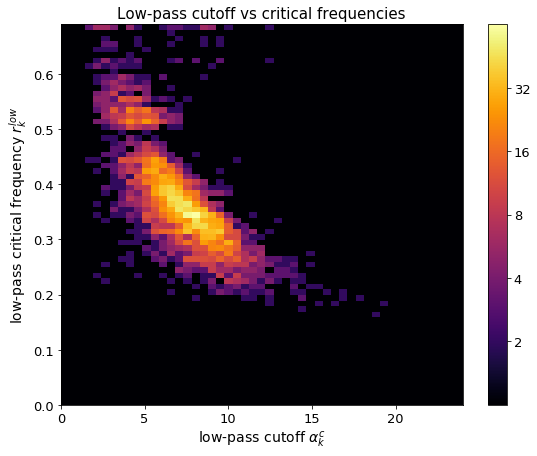

In [48]:
# Generates figure 11
f, ax = plt.subplots(1,1, figsize = (10,7))
xedges = np.linspace(0,0.69,70)
yedges = np.linspace(0,0.69,70)
cmap = 'inferno'
H1, xedges1, yedges1 = np.histogram2d( lowpass_ratio_minimums,highpass_ratio_minimums, bins = (xedges,yedges) )

#using log color schemes to give better picture
X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T+1, cmap = cmap,
              norm = colors.LogNorm(vmin=H1.min()+1, vmax=H1.max()+1))
plt.title('Low-pass vs high-pass\n critical frequencies', size=17)
plt.xlabel('low-pass critical frequency $r_k^{low}$', size = 15)
plt.ylabel('high-pass critical frequency $r_k^{high}$',size = 15)
plt.plot([0,0.69],[0,0.69], c = 'y', linestyle = '--')

cbar = plt.colorbar(ticks = [0,2,4,8,16,32])
cbar.set_ticklabels(['2','4','8', '16','32'])
cbar.ax.tick_params(labelsize=14) 
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.savefig('../paper/figures/crit-comparisons.eps')

###################################################
# generates right side of figure 9
f, ax = plt.subplots(1,1, figsize = (9,7))
xedges = np.linspace(0,0.8,60)
yedges = np.linspace(0,0.69,70)
cmap = 'inferno'
H1, xedges1, yedges1 = np.histogram2d(cutoffs_highpass,highpass_ratio_minimums, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T+1, cmap = cmap,
              norm = colors.LogNorm(vmin=H1.min()+1, vmax=H1.max()+1) )
plt.title('High-pass cutoff vs  critical frequencies', size=15)
plt.ylabel('high-pass critical frequency $r_k^{high}$', size = 14)
plt.xlabel('high-pass cutoff $\sigma_k^c$',size = 14)


cbar = plt.colorbar(ticks = [0,2,4,8,16,32])
cbar.set_ticklabels(['2','4','8', '16','32'])
cbar.ax.tick_params(labelsize=13) 
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.savefig('../paper/figures/crit-vs-sigma.eps')

####################################################
#generates left side of figure 9

f, ax = plt.subplots(1,1, figsize = (9,7))
xedges = np.linspace(0,24,50)
yedges = np.linspace(0,0.69,70)
cmap = 'inferno'
H1, xedges1, yedges1 = np.histogram2d(list(cutoffs_lowpass),lowpass_ratio_minimums, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T+1, cmap = cmap,
              norm = colors.LogNorm(vmin=H1.min()+1, vmax=H1.max()+1) )
plt.title('Low-pass cutoff vs critical frequencies', size=15)
plt.ylabel('low-pass critical frequency $r_k^{low}$', size = 14)
plt.xlabel('low-pass cutoff $\\alpha_k^{c}$',size = 14)

cbar = plt.colorbar(ticks = [0,2,4,8,16,32])
cbar.set_ticklabels(['2','4','8', '16','32'])
cbar.ax.tick_params(labelsize=13) 
plt.xticks(size = 13)
plt.yticks(size = 13)

plt.savefig('../paper/figures/crit-vs-alpha.eps')


In [ ]:
#This block generates the functions a_k^left(r) and a_k^right(r).  We pick 12 choices of r because it is
#actually difficult to compute these
 
os.chdir(curdir)
selected_files=range(161)

#artifact from trying different models. 
modifyNames = ['kernel5', 'kernel7', 'kernel9','kernel11']

[bbc, bkc] = [[],[]] 

os.chdir(caffePath)
big_left_curves= [bbc]
big_right_curves= [bkc]

#This part takes very long.  you can shorten it by doing it for limited subset of range(161)
for m in selected_files:
    eps = 0.0
    height = 1.0
    bbc = []
    bkc = []
    new_data, data_index, data, img, sigmas,img_transform = mef.get_good_img_data(m,good_filenames,label_path,image_path)
    for k in range(len(zfc[m])):

        rrrs = np.linspace(0.05,0.60, 12)
        left_cutoffs = []
        right_cutoffs = []
        start = time.time()
        for r in rrrs:

            #generate the left-justified values e_k^{r,left}
            left_score, cert_score = mef.get_cutoff(good_filenames[m], data_index[k], weights, mod, 
                       image_path, label_path, args = ['bandpass_inverse',0.001, r, eps, 1.0, 'left'],
                       jump = (0.5**0.5)-r, thresh = 0.5, xeps = 0.005, yeps = 0.02, loops = 10, 
                        i = 3,lowbound = 0, highbound = (0.5**0.5)-r)
            left_cutoffs = left_cutoffs+ [left_score]

            #generate the right-justified values e_k^{r,right}
            right_score, cert_score = mef.get_cutoff(good_filenames[m], data_index[k], weights, mod, 
                       image_path, label_path, args=['bandpass_inverse', 0.001, r, eps,1.0,'right'],
                       jump = r, thresh = 0.5, xeps = 0.005, yeps = 0.02, loops = 10, i=3, 
                                                 lowbound = 0, highbound = r)
            right_cutoffs = right_cutoffs+ [right_score]

        #add results to list of functions
        bbc = bbc +[left_cutoffs]
        bkc = bkc + [right_cutoffs]
        end = time.time()
        print "car "+str(k)+": found filter curves in "+str((end - start)/60.0)[:7]+ " minutes..."
        np.save(curdir+"/left-right-pass-curves-"+str(m)+"-"+modifyNames[1]+".npy", [bbc,bkc])

    big_left_curves = big_left_curves+[bbc]
    big_right_curves = big_left_curves+[bkc]
    #np.save(curdir+"/band-knotch-pass-curves-"+str(m)+".npy", [bbc,bkc])

In [ ]:
#creates a bunch of versions of parts of image 13.  thoes in the paper are m = 0, k =0, m = 0, k = 8.
m=0
[bbc, bkc] = np.load('left-right-pass-curves/left-right-pass-curves-'+str(m)+'-kernel7.npy')
for k in range(len(zfc[m])):
    f,ax = plt.subplots(1,3, figsize = (15,5))
    ax[1].scatter(np.linspace(0.05,0.60, 12),np.maximum(0,bbc[k]))
    ax[1].scatter(np.linspace(0.05,0.60, 12),np.maximum(0,bkc[k]))
    ax[1].set_title('Left/ right-justified notch filter cutoff points')
    ax[1].set_xlabel('notch filter radius $r$')
    ax[1].set_ylabel('notch width $\\varepsilon$')
    ax[1].legend(['opens from left', 'opens from right'])

    ax[0].scatter(np.linspace(0,24, 151), zfc[m][k], c='g')
    ax[0].set_xlabel('$\sigma$')
    ax[0].set_ylabel('certainty')
    ax[0].set_title('low-pass certainty curve')
    
    ax[2].set_xlabel('$\sigma$')
    ax[2].set_ylabel('certainty')
    ax[2].set_title('high-pass certainty curve')
    ax[2].scatter(np.linspace(0,1, 151), zfc2[m][k], c='g')

    #plt.savefig('../paper/notch-filters-'+str(m)+'-'+str(k)+'.eps')
    plt.show()
    plt.close()

In [50]:
def bandpass_limits(leftj,rightj): #leftj looks like \_, rightj looks like _/
    
    #Get numbers i $ where leftj[i] = 0 onwards and rightj[i]>0 onward.  
    #Then calculate an average score for the right endpoint. by taking r[i] - rightj[i]


    r = np.linspace(0.05, 0.6,12)
    leftoptions =[]
    rightoptions =[]
    centeroptions = []
    i = 11
    while (leftj[i] == 0) and i >= 0:
        #print i
        if rightj[i] > 0: 
            rightoptions+=[r[i]-rightj[i]]
            #print rightoptions[-1]
        else: centeroptions+= [r[i]]
        i =i-1
    
    j = 0
    while (rightj[j] == 0)and j < 12:
        if leftj[j] > 0: 
            leftoptions+=[r[j]+leftj[j]]
        else: centeroptions+= [r[j]]
        j +=1
    
    if j<1: 
        if i > 0: leftboundary = np.average((r+leftj)[:i])
        else: leftboundary = 0
        badcarmark = 1
        
    else:
        leftboundary = np.average(leftoptions[:-1])
        leftboundary = np.average((r+leftj)[:i])
        badcarmark = 0
        
    rightboundary = np.average(rightoptions)
    
    return (leftboundary, rightboundary, badcarmark)
    #for the possible left endpoint, get numbers last number i in rightj[i] 
    #with rightj[i] = 0 and leftj[i] > 0 before all i.  If no such number exists, we let 
    #left endpoint = 0 and 'mark the car' in some way
    

In [51]:
os.chdir(curdir)
goodpoints = [[],[]]
badpoints = [[],[]]
s = 0
for m in range(161):
    [bbc, bkc] = np.load('left-right-pass-curves/left-right-pass-curves-'+str(m)+'-kernel7.npy')
    for k in range(len(zfc[m])):
        if zfc[m][k][0]>0.527:
            
            (x,y,a) = bandpass_limits(np.maximum(0,bbc[k]),np.maximum(0,bkc[k])) #leftj looks like \_, rightj looks like _/
            if np.isnan(x): x = 0
            if np.isnan(y): y = 0
            if cutoffs_highpass[s] > 0.1:# a == 0:

                goodpoints[0],goodpoints[1] = goodpoints[0]+ [x],goodpoints[1]+[y]
            if cutoffs_highpass[s] <= 0.1: # a == 1:
                badpoints[0],badpoints[1] = badpoints[0]+[x],badpoints[1]+[y]
            s += 1 

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


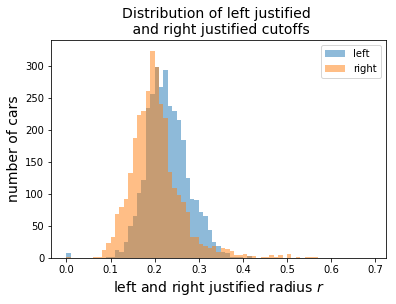

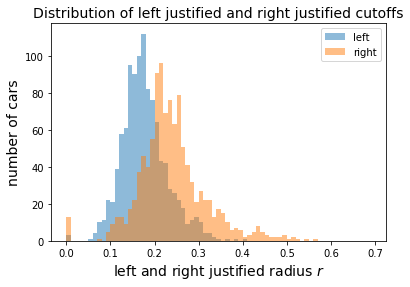

In [55]:
#generates figure 18


plt.figure()
plt.title('Distribution of left justified \n and right justified cutoffs',size = 14)
plt.hist(goodpoints[0],bins =np.linspace(0,0.69,70), alpha = 0.5)
plt.hist(goodpoints[1],bins =np.linspace(0,0.69,70),alpha = 0.5)
plt.xlabel('left and right justified radius $r$',size = 14)
plt.ylabel('number of cars',size = 14)
plt.legend(['left', 'right'])
plt.savefig('../paper/figures/justified-frequency-1D-histogram.eps')

plt.figure()
plt.title('Distribution of left justified and right justified cutoffs',size = 14)
plt.hist(badpoints[0],bins =np.linspace(0,0.69,70), alpha = 0.5)
plt.hist(badpoints[1],bins =np.linspace(0,0.69,70),alpha = 0.5)
plt.xlabel('left and right justified radius $r$',size = 14)
plt.ylabel('number of cars',size = 14)
plt.legend(['left', 'right'])
plt.savefig('../paper/figures/bad-justified-frequency-1D-histogram.eps')

In [56]:
#generates a_k^delta(r) for all cars, with delta = 0.1

huge_initial_cutoff = []

for m in range(len(good_filenames)):
    start = time.time()
    new_data, data_index, data, img, sigmas,transform = mef.get_good_img_data(m,good_filenames,label_path,image_path)
    filt_img_max = mef.filter_application(transform, args = ['highpass', 0, 0,0])

    filt_img_min = mef.filter_application(transform,args = ['highpass', 0.1,0,0])

    for k in range(len(zfc[m])):

        if zfc[m][k][0] > 0.527:

            ratio_line_initial = []
            
            Maxpic,maxcar = mef.small_fourier(filt_img_max, new_data[k],2,0,0)
            Minpic, mincar = mef.small_fourier(filt_img_min, new_data[k],2,0,0)
            ratios = np.minimum(100,np.abs(Minpic)/np.abs(Maxpic))
            for r in rrrs:

                ratio_line_initial = ratio_line_initial+ [mef.interpolated_frequency_spectrum(ratios,r=r, n = 40)]
  

            huge_initial_cutoff += [ratio_line_initial]

    end = time.time()
    print "went through cars in image "+str(m)+ " in "+str(end-start)[:5]+ " seconds..."    

went through cars in image 0 in 2.548 seconds...
went through cars in image 1 in 2.240 seconds...
went through cars in image 2 in 1.774 seconds...
went through cars in image 3 in 2.329 seconds...
went through cars in image 4 in 2.353 seconds...
went through cars in image 5 in 1.703 seconds...
went through cars in image 6 in 2.378 seconds...
went through cars in image 7 in 4.076 seconds...
went through cars in image 8 in 2.495 seconds...
went through cars in image 9 in 2.807 seconds...
went through cars in image 10 in 2.835 seconds...
went through cars in image 11 in 1.295 seconds...
went through cars in image 12 in 2.830 seconds...
went through cars in image 13 in 2.087 seconds...
went through cars in image 14 in 2.330 seconds...
went through cars in image 15 in 2.173 seconds...
went through cars in image 16 in 2.811 seconds...
went through cars in image 17 in 1.851 seconds...
went through cars in image 18 in 1.513 seconds...
went through cars in image 19 in 2.145 seconds...
went throu

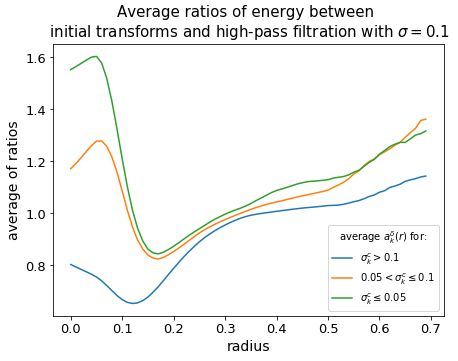

In [98]:
#generates figure 12

#average curves for figure 12
huge_initial_cutoff_good = np.average(np.array([huge_initial_cutoff[s] for s in range(len(cutoffs_highpass)) if cutoffs_highpass[s] > 0.1]),axis = 0)
huge_initial_cutoff_middle = np.average(np.array([huge_initial_cutoff[s] for s in range(len(cutoffs_highpass)) if (cutoffs_highpass[s] > 0.05 and cutoffs_highpass[s] <= 0.1)]),axis = 0)
huge_initial_cutoff_bad = np.average(np.array([huge_initial_cutoff[s] for s in range(len(cutoffs_highpass)) if cutoffs_highpass[s] <= 0.05]),axis = 0)


plt.figure(figsize = (7,5))
plt. plot(np.linspace(0, 0.69, 70), huge_initial_cutoff_good)
plt.plot(np.linspace(0,0.69, 70), huge_initial_cutoff_middle)
plt.plot(np.linspace(0,0.69, 70), huge_initial_cutoff_bad)
plt.title('Average ratios of energy between \n initial transforms and high-pass filtration with $\sigma = 0.1$ ', size = 15)
plt.xlabel('radius', size = 14)
plt.ylabel('average of ratios',size = 14)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.legend(['$\sigma_k^c > 0.1$','$0.05 < \sigma_k^c \leq 0.1$','$\sigma_k^c \leq 0.05$'], title='average $a_k^\delta(r)$ for:')

plt.savefig('../paper/figures/initial-ratios.eps')

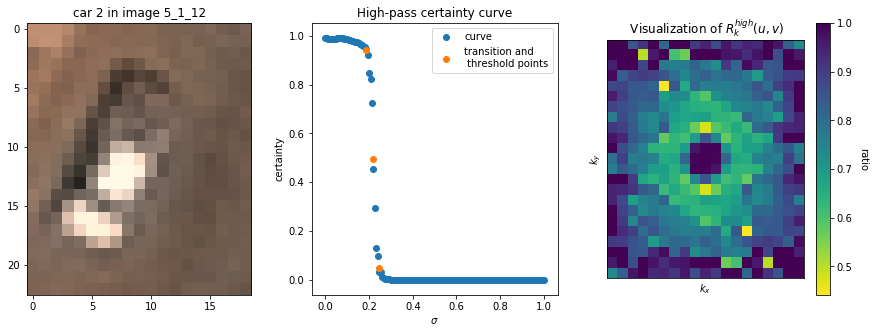

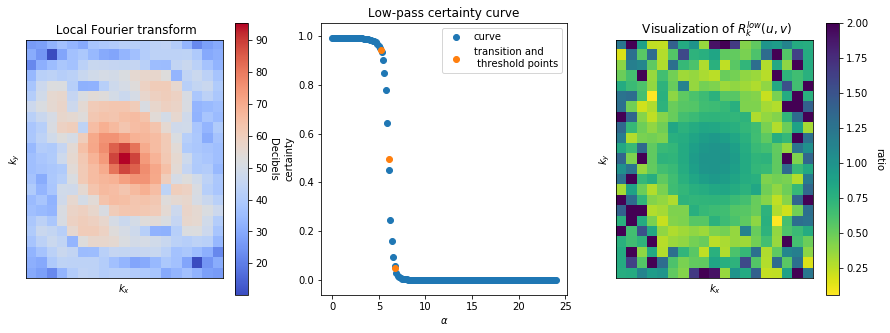

In [62]:
#generates both parts of figure 6
m=8
k=2
t=1

z=zfc2[m][k]
filtertype = 'highpass'
f, ax = plt.subplots(1,3, figsize = (15,5))
new_data, data_index, data, img, sigmas,transform = mef.get_good_img_data(m, good_filenames,label_path,image_path)
[left,up,right,down] = new_data[k]


ax[0].set_title('car '+str(k)+' in image '+good_filenames[m])

#Find lowpass cutoff
sigmas = np.linspace(0,1,151)
[cutoff, sigmax, sigmin],zargmax, zargmin = mef.find_midpoint_of_curve(z, sigmas,absolute = 1)
[sigmax, sig1, sig2],_,_ = mef.find_midpoint_of_curve(z, sigmas,threshold = 0.95)
[sigmin, sig1, sig2],_,_ = mef.find_midpoint_of_curve(z, sigmas, threshold = 0.05)


#graph of highpass certainty curve
ax[1].scatter(sigmas, z)
ax[1].scatter([cutoff,sigmax,sigmin],[0.5*(z[zargmax]+z[zargmin]),
                                      0.95*z[zargmax]+0.05*z[zargmin],
                                      0.05*z[zargmax]+0.05*z[zargmin]])
ax[1].set_title('High-pass certainty curve')
ax[1].legend(['curve','transition and \n threshold points'])
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('certainty')

#image of car
filt_img_max = mef.filter_application(transform, args = [filtertype, sigmax, 0,0])    
filt_img_min = mef.filter_application(transform,args = [filtertype, sigmin,0,0])
Maxpic,maxcar = mef.small_fourier(filt_img_max, new_data[k],2,0,0)
Minpic, mincar = mef.small_fourier(filt_img_min, new_data[k],2,0,0)
orig_transform, orig_car = mef.small_fourier(img, new_data[k],2,0,0)
ax[0].imshow(orig_car)

ratios = np.minimum(t,np.abs(Minpic)/np.abs(Maxpic))
sm = plt.cm.ScalarMappable(cmap='viridis_r' ,
        norm=plt.Normalize(vmin=np.min(ratios), vmax=np.max(ratios) ))
sm._A = []
clb = f.colorbar(sm, ax=ax[2])
a=ax[2].imshow(ratios, cmap = 'viridis_r')
#f.colorbar(a[i][j],ax=ax[i,j])
a.set_clim(np.min(ratios),np.max(ratios))
clb.set_label('ratio', labelpad=15, rotation=270)
ax[2].title.set_text(' Visualization of $R^{high}_k(u,v)$')
ax[2].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
ax[2].set_xlabel('$k_x$')
ax[2].set_ylabel('$k_y$') 
plt.savefig('../paper/figures/fourier-ratios-highpass.eps')

####################################

#get lowpass cutoff and thresholds
f, ax = plt.subplots(1,3, figsize = (15, 5))
filtertype = 'lowpass'
z = zfc[m][k]
t=2
sigmas = np.linspace(0,24,151)
[cutoff, sigmax, sigmin],zargmax, zargmin = mef.find_midpoint_of_curve(z, sigmas,absolute = 1)
[sigmax, sig1, sig2],_,_ = mef.find_midpoint_of_curve(z, sigmas,threshold = 0.95)
[sigmin, sig1, sig2],_,_ = mef.find_midpoint_of_curve(z, sigmas, threshold = 0.05)


#plot certainty curve
ax[1].scatter(sigmas, z)
ax[1].scatter([cutoff,sigmax,sigmin],[0.5*(z[zargmax]+z[zargmin]),
                                      0.95*z[zargmax]+0.05*z[zargmin],
                                      0.05*z[zargmax]+0.05*z[zargmin]])
ax[1].set_title('Low-pass certainty curve')
ax[1].legend(['curve','transition and \n threshold points'])
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('certainty')


filt_img_max = mef.filter_application(transform, args = [filtertype, sigmax, 0,0])       
filt_img_min = mef.filter_application(transform,args = [filtertype, sigmin,0,0])
Maxpic,maxcar = mef.small_fourier(filt_img_max, new_data[k],2,0,0)
Minpic, mincar = mef.small_fourier(filt_img_min, new_data[k],2,0,0)

#plot fourier transform ratio
ratios = np.minimum(t,np.abs(Minpic)/np.abs(Maxpic))
sm = plt.cm.ScalarMappable(cmap='viridis_r' ,
        norm=plt.Normalize(vmin=np.min(ratios), vmax=np.max(ratios) ))
sm._A = []
clb = f.colorbar(sm, ax=ax[2])
a=ax[2].imshow(ratios, cmap = 'viridis_r')
a.set_clim(np.min(ratios),np.max(ratios))
clb.set_label('ratio', labelpad=15, rotation=270)
ax[2].title.set_text(' Visualization of $R^{low}_k(u,v)$')
ax[2].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
ax[2].set_xlabel('$k_x$')
ax[2].set_ylabel('$k_y$') 



#plot original fourier transform
car_energy = 10*mef.Q(orig_transform)
sm2 = plt.cm.ScalarMappable(cmap='coolwarm' ,
        norm=plt.Normalize(vmin=np.min(car_energy), vmax=np.max(car_energy) ))
sm2._A = []
clb2 = f.colorbar(sm2, ax=ax[0])
#a=ax[].imshow(ratios, cmap = 'coolwarm')
#f.colorbar(a[i][j],ax=ax[i,j])

a2 = ax[0].imshow(car_energy, cmap = 'coolwarm')
a2.set_clim(np.min(car_energy),np.max(car_energy))
ax[0].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
ax[0].set_xlabel('$k_x$')
ax[0].set_ylabel('$k_y$') 
clb2.set_label('Decibels', labelpad=10, rotation=270)
ax[0].title.set_text(' Local Fourier transform')
plt.savefig('../paper/figures/fourier-ratios-lowpass.eps')

In [63]:
x = []
y1 = []
y2 = []
rrrss=[]
minratioslow = []
minratioshigh = []
energyCritFreqLow = []
energyCritFreqHigh = []
for s in range(len(huge_rll)):
    for r in range(len(huge_rll[s])):
        x+= [huge_il[s][r]]
        y1+= [huge_rll[s][r]]
        y2+= [huge_rlh[s][r]]
    rrrss += list(rrrs)
    minratioslow+= [rrrs[np.argmin(huge_rll[s])]]
    minratioshigh+= [rrrs[np.argmin(huge_rlh[s])]]
    energyCritFreqLow+= [huge_il[s][np.argmin(huge_rll[s])]]
    energyCritFreqHigh+= [huge_il[s][np.argmin(huge_rlh[s])]]

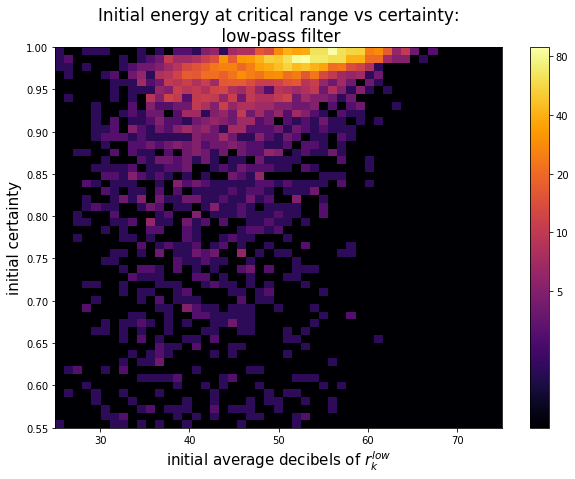

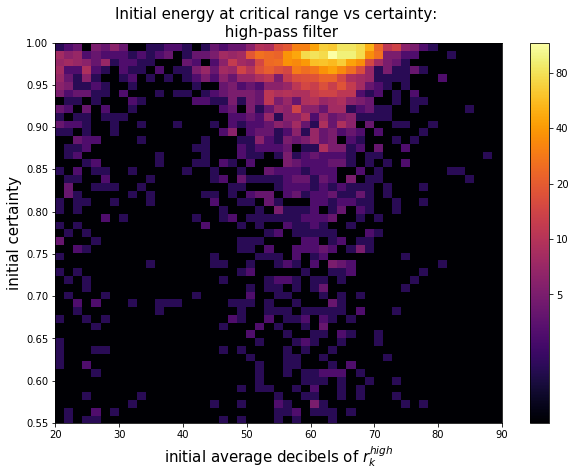

In [64]:
#generates left side of figure 14
f, ax = plt.subplots(1,1, figsize = (10,7))
xedges = np.linspace(25,75,50)
yedges = np.linspace(0.55,1,50)
cmap = 'inferno'
H1, xedges1, yedges1 = np.histogram2d(10*np.log(np.array(energyCritFreqLow)+1), lp_certainties, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T+1, cmap = cmap,
              norm = colors.LogNorm(vmin=H1.min()+1, vmax=H1.max()+1) )

plt.title('Initial energy at critical range vs certainty:\n low-pass filter', size=17)
plt.ylabel('initial certainty', size = 15)
plt.xlabel('initial average decibels of $r_k^{low}$',size = 15)
plt.colorbar(ticks = [5,10,20,40,80,160]).set_ticklabels(['5','10','20','40','80','160'])
plt.savefig('../paper/figures/energy-levels-lowpass.eps')
#####################################

#generates right side of figure 14
f, ax = plt.subplots(1,1, figsize = (10,7))
xedges = np.linspace(20,90,50)
yedges = np.linspace(0.55,1,50)
cmap = 'inferno'
H1, xedges1, yedges1 = np.histogram2d(10*np.log(np.array(energyCritFreqHigh)+1), lp_certainties, bins = (xedges,yedges) )

X,Y = np.meshgrid(xedges1,yedges1)
plt.pcolormesh(X,Y,H1.T+1, cmap = cmap,
              norm = colors.LogNorm(vmin=H1.min()+1, vmax=H1.max()+1) )
plt.title('Initial energy at critical range vs certainty: \n high-pass filter', size=15)
plt.ylabel('initial certainty', size = 15)
plt.xlabel('initial average decibels of $r_k^{high}$',size = 15)
plt.colorbar(ticks = [5,10,20,40,80,160]).set_ticklabels(['5','10','20','40','80','160'])
plt.savefig('../paper/figures/energy-levels-highpass.eps')

In [68]:
#a slightly different version of the above function, this one is for the notch filters

def certainty_pdf(z,filtertype):
    z_cars = [car for listcar in z for car in listcar]
    k = 70
    plt.figure(figsize = (10,7))
    z_car_ind_scores = [[score[i] for score in z_cars] for i in range(k)]
    if filtertype == 'notch':
        sigmas = np.linspace(0,0.69,70)
        m =1
        print m

    plt.title('Reversed cdf of ' +filtertype+ ' certainty score \n in all images', size = 20)
    plt.xlabel('certainty scores', size = 15)
    plt.xticks(size = 13)
    plt.ylabel('number of cars', size = 15)

    c = np.arange(1., len(range(0,70,m)))[::1]

    cmap = plt.get_cmap("RdYlGn", len(c))
    norm = colors.BoundaryNorm(sigmas[0:k:m],len(c))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    for i,sigma_hist in enumerate(z_car_ind_scores[k:0:-m]):
        plt.hist(sigma_hist,bins =np.linspace(0,1,101), histtype = 'step',
                 cumulative=-1, label='Empirical', color=cmap(k/m - i), alpha = 1, linewidth = 3)

    cbar = plt.colorbar(sm, ticks = sigmas[::10*m])
    cbar.ax.tick_params(labelsize = 13)
    cbar.ax.set_title('$r$')
    
    #change title number to 10 if using notch with eps = 0.1, or 05 if using notch with eps = 0.5
    plt.savefig('../paper/figures/certainty-histograms-distribution-'+filtertype+'10.eps')
    plt.show()
    plt.close()
    

In [66]:
Coverages = np.load('cvgs_20_plus-bandpass_inverse-notch-05.npy')
zfm = []
zfc = []
zfb = []
#create a collection of uncertainty curves.
for k in range(0,len(good_filenames)):#len(good_filenames)):
    new_data, data_index, data, img, sigmas,img_transform = mef.get_good_img_data(k,good_filenames,label_path,image_path)

    for i in range(len(new_data)):
        new_data[i] = np.append(new_data[i],1)
    new_data = np.asarray(new_data)
    if len(new_data) > 0:
        z = mef.prediction_certainty_curve(new_data*4,Coverages[k], thresh=0.0, avg = 'center', sigtimes = 70)
        zfc = zfc+[z]
    else:    
        zfc = zfc+[[]]

Coverages = np.load('cvgs_20_plus-bandpass_inverse-notch-10.npy')
zfm = []
zfc2 = []
zfb = []
#create a collection of uncertainty curves. 
for k in range(0,len(good_filenames)):

    new_data, data_index, data, img, sigmas,img_transform = mef.get_good_img_data(k,good_filenames,label_path,image_path)

    for i in range(len(new_data)):
        new_data[i] = np.append(new_data[i],1)
    new_data = np.asarray(new_data)

    if len(new_data) > 0:
        z = mef.prediction_certainty_curve(new_data*4,Coverages[k], thresh=0.0, avg = 'center', sigtimes = 70)
        zfc2 = zfc2+[z]

    else:    
        zfc2 = zfc2+[[]]


1


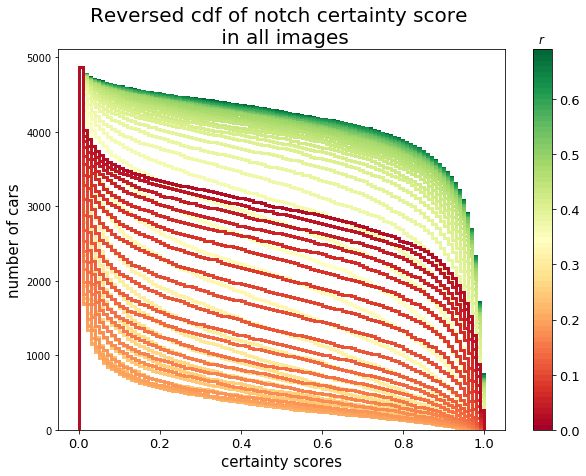

161


In [69]:
# generate figures 20 and 21.  though you have to change the titles in each
certainty_pdf(zfc2,'notch')
print len(zfc2)